In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import data_utils
import train_utils
import models

%reload_ext autoreload
%autoreload 2


n_conv_layers = 2
kernel_size = [4,3]
n_conv_filters = [36,48]
hidden_size = 512
n_rnn_layers = 2
dropout=0.5
gen = models.Generator(n_conv_layers, kernel_size, n_conv_filters, hidden_size, n_rnn_layers, dropout=dropout)
state_dict = torch.load('generator_retrain.pt')
gen.load_state_dict(state_dict)
gen = gen.cuda()

n_conv_layers = 2
n_fc_layers = 2
kernel_size = [4,3]
n_conv_filters = [36,48]
hidden_size = [512,512]
dropout=0.5
enc = models.ConvNet(n_conv_layers, n_fc_layers, kernel_size, n_conv_filters, hidden_size, dropout=dropout)
state_dict = torch.load('encoder_retrain.pt')
enc.load_state_dict(state_dict)
enc = enc.cuda()


In [2]:
def compute_rationales(valid_loader, gen, enc, pool_fn):
    gen.eval()
    enc.eval()
    
    labels = []
    selectors = []

    for slide,label in valid_loader:
        slide, label = slide.squeeze(0).cuda(), label.cuda()

        prez = gen(slide)
        z = torch.argmax(prez, dim=2).squeeze(0)
        rationale = slide[z==1,:,:,:]
        selectors.append(z)
        labels.extend(label.float().cpu().numpy())
    return labels,selectors

In [8]:
def pool_fn(x):
    v = torch.mean(x,0)
    return v
train = data_utils.COAD_dataset(data_utils.COAD_TRAIN)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True , pin_memory=True)

valid = data_utils.COAD_dataset(data_utils.COAD_VALID)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False , pin_memory=True)
labels,selectors = compute_rationales(valid_loader, gen, enc, pool_fn)

In [11]:
selectors_cancer = []
cell_label_cancer = []
for idx,(avec,cell_labels) in enumerate(zip(selectors,valid.cell_labels)):
    if labels[idx]==1:
        selectors_cancer.extend(avec)
        cell_label_cancer.extend(cell_labels)

In [17]:
s_c = torch.stack(selectors_cancer).detach().cpu().numpy()

In [30]:
import pandas as pd
results = pd.DataFrame({'selector':s_c,'cell_label':np.stack(cell_label_cancer)})

In [32]:
results.groupby('cell_label').sum()

,selector
cell_label,
epi,78
fibro,0
inf,0
other,0


In [33]:
selectors_normal = []
cell_label_normal = []
for idx,(avec,cell_labels) in enumerate(zip(selectors,valid.cell_labels)):
    if labels[idx]==0:
        selectors_normal.extend(avec)
        cell_label_normal.extend(cell_labels)

In [34]:
s_n = torch.stack(selectors_normal).detach().cpu().numpy()

In [35]:
results = pd.DataFrame({'selector':s_n,'cell_label':np.stack(cell_label_normal)})

In [36]:
results.groupby('cell_label').sum()

,selector
cell_label,
fibro,51
inf,4
other,2


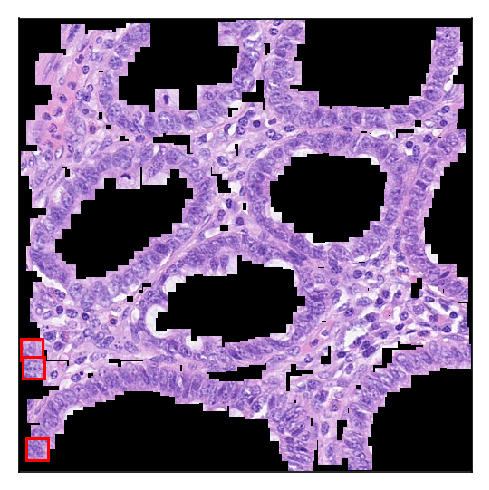

In [40]:
fig = data_utils.draw_image_with_rationale(35,valid,gen)

In [41]:
fig.savefig('Example_Slide_with_rationales.png')